In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
#DADOS DO PROBLEMA
N = 12
Do = 2e-2
A = np.pi * (Do**2) / 4.0
mu = 1e-3
rho = 1e3
dt = 1.0
L = 5.0
Uin = 10.0
dx = L / (N - 2) # dx baseado nos volumes reais
n_iter_global = 100
n_iter_massa = 2

#Inicialização
u = np.ones(N) * Uin
p = np.zeros(N)
u_old = u.copy()
x_p = np.zeros(N)

#Posicionamento dos nós (incluindo fictícios)
for i in range(1, N-1):
    x_p[i] = (i - 0.5) * dx
x_p[0], x_p[N-1] = 0.0, L

In [28]:
#Solver TDMA
def tdma(a, b, c, d):
    n = len(d)
    P, Q, T = np.zeros(n), np.zeros(n), np.zeros(n)
    P[0], Q[0] = c[0]/a[0], d[0]/a[0]
    for i in range(1, n):
        den = a[i] - b[i]*P[i-1]
        P[i] = c[i]/den
        Q[i] = (d[i] + b[i]*Q[i-1])/den
    T[-1] = Q[-1]
    for i in range(n-2, -1, -1):
        T[i] = P[i]*T[i+1] + Q[i]
    return T

hist_uN = []
hist_dp = []

In [ ]:
hist_uN = []
hist_dp = []
residuos_u = [] # Para o gráfico de convergência

u = np.ones(N) * Uin
p = np.linspace(10, 0, N) # Gradiente inicial
u_old = u.copy()

for it in range(n_iter_global):
    # Resoluçãao QML
    aw_u, ae_u, ap_u, bp_u = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    
    for i in range(1, N-1):
        Fe = rho * u[i] * A
        Fw = rho * u[i-1] * A
        De = mu * A / dx
        
        # Esquema UDS na advecção e CDS na difusão
        aw_u[i] = De + max(Fw, 0)
        ae_u[i] = De + max(-Fe, 0)
        ap_u[i] = (rho * A * dx / dt) + aw_u[i] + ae_u[i] + (Fe - Fw)
        
        # Gradiente de Pressão (CDS)
        grad_p = A * (p[i+1] - p[i-1]) / 2.0
        bp_u[i] = (rho * A * dx / dt) * u_old[i] - grad_p

    # CC Fictícios Velocidade
    ap_u[0], bp_u[0] = 1.0, Uin
    ap_u[N-1], aw_u[N-1], bp_u[N-1] = 1.0, 1.0, 0.0
    
    u_new = tdma(ap_u, aw_u, ae_u, bp_u)
    
    # Cálculo do Resíduo
    residuos_u.append(np.linalg.norm(u_new - u))
    u = u_new.copy()

    #Ciclo da Massa (Correção de Pressão)
    for _ in range(n_iter_massa):
        aw_p, ae_p, ap_p, bp_p = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
        for i in range(1, N-1):
            aw_p[i] = 1.0
            ae_p[i] = 1.0
            ap_p[i] = aw_p[i] + ae_p[i]
            # O termo fonte da pressão é o erro de massa (divergência)
            bp_p[i] = -(rho * A * (u[i] - u[i-1]))
            
        ap_p[0], bp_p[0] = 1.0, 0.0 # Referência de pressão
        ap_p[N-1], aw_p[N-1], bp_p[N-1] = 1.0, 1.0, 0.0
        p = tdma(ap_p, aw_p, ae_p, bp_p)

    hist_uN.append(u[N-1])
    hist_dp.append(p[1] - p[N-1])
    u_old = u.copy()


In [ ]:
#PÓS PROCESSAMENTO
u_final = u.copy()
p_final = p.copy()
u_final[0] = Uin
u_final[N-1] = (u[N-2] + u[N-1]) / 2.0
p_final[0] = (p[0] + p[1]) / 2.0
p_final[N-1] = (p[N-2] + p[N-1]) / 2.0
p_final = p_final - p_final[0] # Normalização p(1) = 0

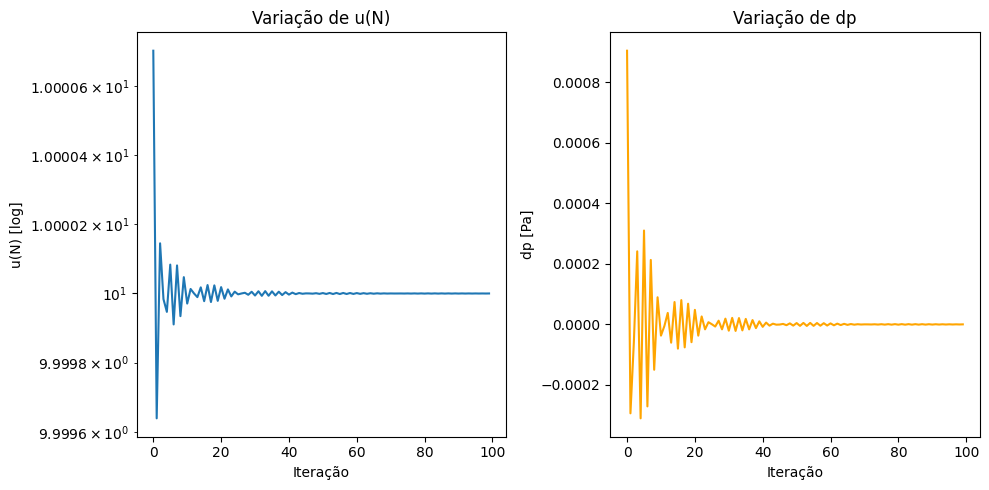

In [31]:
#ITEM 1
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.semilogy(np.abs(hist_uN), label='u(N)')
plt.title('Variação de u(N)')
plt.xlabel('Iteração'); plt.ylabel('u(N) [log]')

plt.subplot(1, 2, 2)
plt.plot(hist_dp, label='dp = p(2)-p(N)', color='orange')
plt.title('Variação de dp')
plt.xlabel('Iteração'); plt.ylabel('dp [Pa]')
plt.tight_layout()
plt.show()

--- Tabela Itens 2 e 3 ---
 Nó   xP       aw           ae       ap        bp   uP
  1 0.00 0.000000 0.000000e+00 1.000000 10.000000 10.0
  2 0.25 3.141593 6.283185e-07 3.298674  1.570796 10.0
  3 0.75 3.141593 6.283185e-07 3.298674  1.570796 10.0
  4 1.25 3.141593 6.283185e-07 3.298674  1.570796 10.0
  5 1.75 3.141593 6.283185e-07 3.298674  1.570796 10.0
  6 2.25 3.141593 6.283185e-07 3.298674  1.570796 10.0
  7 2.75 3.141593 6.283185e-07 3.298674  1.570796 10.0
  8 3.25 3.141593 6.283185e-07 3.298674  1.570796 10.0
  9 3.75 3.141593 6.283185e-07 3.298674  1.570796 10.0
 10 4.25 3.141593 6.283185e-07 3.298674  1.570796 10.0
 11 4.75 3.141593 6.283185e-07 3.298674  1.570796 10.0
 12 5.00 1.000000 0.000000e+00 1.000000  0.000000 10.0


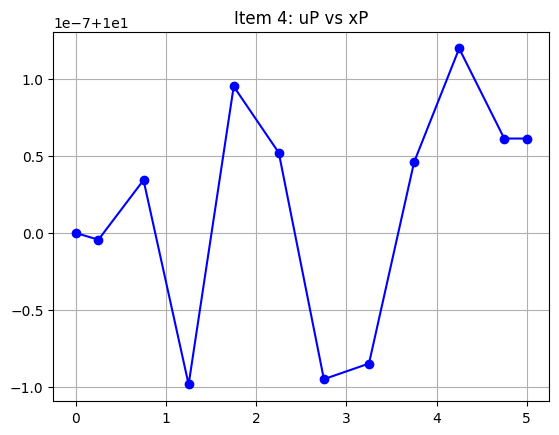

In [32]:
#ITEM 2, 3 E 4
data_u = {'Nó': np.arange(1, N+1), 'xP': x_p, 'aw': aw_u, 'ae': ae_u, 'ap': ap_u, 'bp': bp_u, 'uP': u_final}
df_u = pd.DataFrame(data_u)
print("--- Tabela Itens 2 e 3 ---")
print(df_u.to_string(index=False))

plt.figure()
plt.plot(x_p, u_final, 'bo-')
plt.title('Item 4: uP vs xP')
plt.grid(True); plt.show()


--- Tabela Item 5 (Faces Leste) ---
 Nó   xe   ue
  1 0.25 10.0
  2 0.50 10.0
  3 1.00 10.0
  4 1.50 10.0
  5 2.00 10.0
  6 2.50 10.0
  7 3.00 10.0
  8 3.50 10.0
  9 4.00 10.0
 10 4.50 10.0
 11 5.00 10.0
 12 5.00  0.0


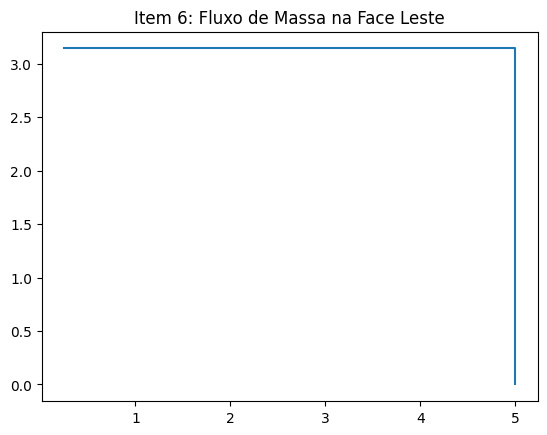

In [33]:
#ITEM 5 E 6
xe = x_p + dx/2
xe[-1] = L
ue = np.zeros(N)
fluxo = np.zeros(N)
for i in range(N-1):
    ue[i] = (u_final[i] + u_final[i+1]) / 2
    fluxo[i] = rho * ue[i] * A

print("\n--- Tabela Item 5 (Faces Leste) ---")
print(pd.DataFrame({'Nó': np.arange(1, N+1), 'xe': xe, 'ue': ue}).to_string(index=False))

plt.figure()
plt.step(xe, fluxo, where='post')
plt.title('Item 6: Fluxo de Massa na Face Leste')
plt.show()


--- Tabela Itens 7 e 8 ---
 Nó   xP  aw  ap  ae            bp            pP
  1 0.00 0.0 1.0 0.0  0.000000e+00  0.000000e+00
  2 0.25 1.0 2.0 1.0  1.367243e-09 -9.624138e-09
  3 0.75 1.0 2.0 1.0 -1.214768e-08 -3.023966e-08
  4 1.25 1.0 2.0 1.0  4.164258e-08 -3.870750e-08
  5 1.75 1.0 2.0 1.0 -6.073027e-08 -8.881792e-08
  6 2.25 1.0 2.0 1.0  1.352290e-08 -7.819808e-08
  7 2.75 1.0 2.0 1.0  4.612454e-08 -8.110112e-08
  8 3.25 1.0 2.0 1.0 -3.182806e-09 -1.301287e-07
  9 3.75 1.0 2.0 1.0 -4.101957e-08 -1.759735e-07
 10 4.25 1.0 2.0 1.0 -2.317518e-08 -1.807987e-07
 11 4.75 1.0 2.0 1.0  1.834997e-08 -1.624487e-07
 12 5.00 1.0 1.0 0.0  0.000000e+00 -1.624487e-07


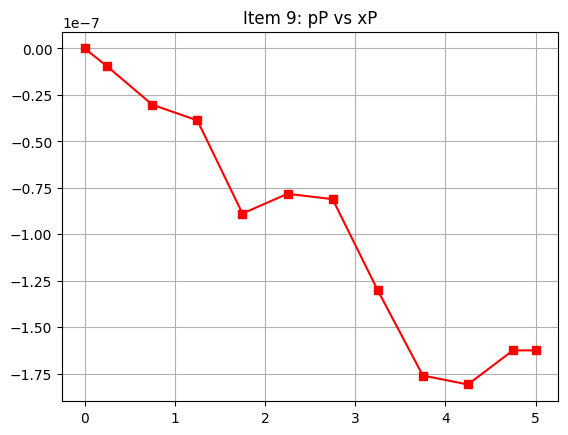

In [34]:
#ITEM 7, 8 E 9
data_p = {'Nó': np.arange(1, N+1), 'xP': x_p, 'aw': aw_p, 'ap': ap_p, 'ae': ae_p, 'bp': bp_p, 'pP': p_final}
df_p = pd.DataFrame(data_p)
print("\n--- Tabela Itens 7 e 8 ---")
print(df_p.to_string(index=False))

plt.figure()
plt.plot(x_p, p_final, 'rs-')
plt.title('Item 9: pP vs xP')
plt.grid(True); plt.show()